# Transformer model fitting

This notebook contains the fitting of the Transformer model to all series in the dataset at the same time.

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Transformers.model_selection import TransformerHyperTune
from Transformers.data_processing import window_dataset_sequence_to_sequence
from DataSimulation.utils import plot_fit

In [2]:
data = pd.read_csv('data.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,11.0,4.0,43.0,31.0,15.0,3.0,56.0,7.0,322.0
1,35.0,7.0,4.0,14.0,26.0,13.0,0.0,51.0,4.0,232.0
2,10.0,4.0,5.0,9.0,43.0,44.0,4.0,39.0,3.0,416.0
3,33.0,7.0,4.0,23.0,13.0,33.0,0.0,38.0,11.0,912.0
4,4.0,4.0,4.0,17.0,16.0,21.0,2.0,52.0,14.0,3409.0


In [3]:
test_size = 12
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(188, 10)
(12, 10)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)

In [5]:
parameters = {
    "num_layers":[2],
    "num_heads":[4,6],
    "dff":[8,16],
    "dropout_rate":[0.1,0.3],
    "learning_rate":[0.01, 0.001],
    "batch_size":[1,16,32]
}

In [6]:
transformer_hypertune = TransformerHyperTune(
    num_features=10,
    window_size=12,
    parameters=parameters
)

In [14]:
transformer_model, scaler = transformer_hypertune.fit(
    data=train_data,
    checkpoint_path=os.path.join(os.getcwd(), 'checkpoint'),
    epochs=500
)

Training model 0/48.
minimum 0 model's validation loss: 0.03900698199868202.
Training model 1/48.
minimum 1 model's validation loss: 0.03939076140522957.
Training model 2/48.
minimum 2 model's validation loss: 0.03912898898124695.
Training model 3/48.
minimum 3 model's validation loss: 0.041072167456150055.
Training model 4/48.
minimum 4 model's validation loss: 0.04049306362867355.
Training model 5/48.
minimum 5 model's validation loss: 0.03935297951102257.
Training model 6/48.
minimum 6 model's validation loss: 0.0390893891453743.
Training model 7/48.
minimum 7 model's validation loss: 0.039583902806043625.
Training model 8/48.
minimum 8 model's validation loss: 0.038751184940338135.
Training model 9/48.
minimum 9 model's validation loss: 0.039147622883319855.
Training model 10/48.
minimum 10 model's validation loss: 0.03997872397303581.
Training model 11/48.
minimum 11 model's validation loss: 0.041492361575365067.
Training model 12/48.
minimum 12 model's validation loss: 0.03917253

time: 415m 55.8s

In [15]:
transformer_hypertune.best_params

{'num_layers': 2,
 'num_heads': 6,
 'dff': 16,
 'dropout_rate': 0.1,
 'learning_rate': 0.001,
 'batch_size': 32}

In [16]:
scaled_data = scaler.transform(data)

In [18]:
eval_ds = window_dataset_sequence_to_sequence(
    data=scaled_data,
    sequence_lenght=12,
    output_lenght=12,
    batch_size=scaled_data.shape[0],
    shift=1,
    shuffle=False    
)

In [19]:
fit_values = transformer_model.predict(eval_ds)
fit_0 = fit_values[:,0,:]

1/1 [==============================] - 2s 2s/step


In [20]:
orig_scale = scaler.inverse_transform(fit_0)

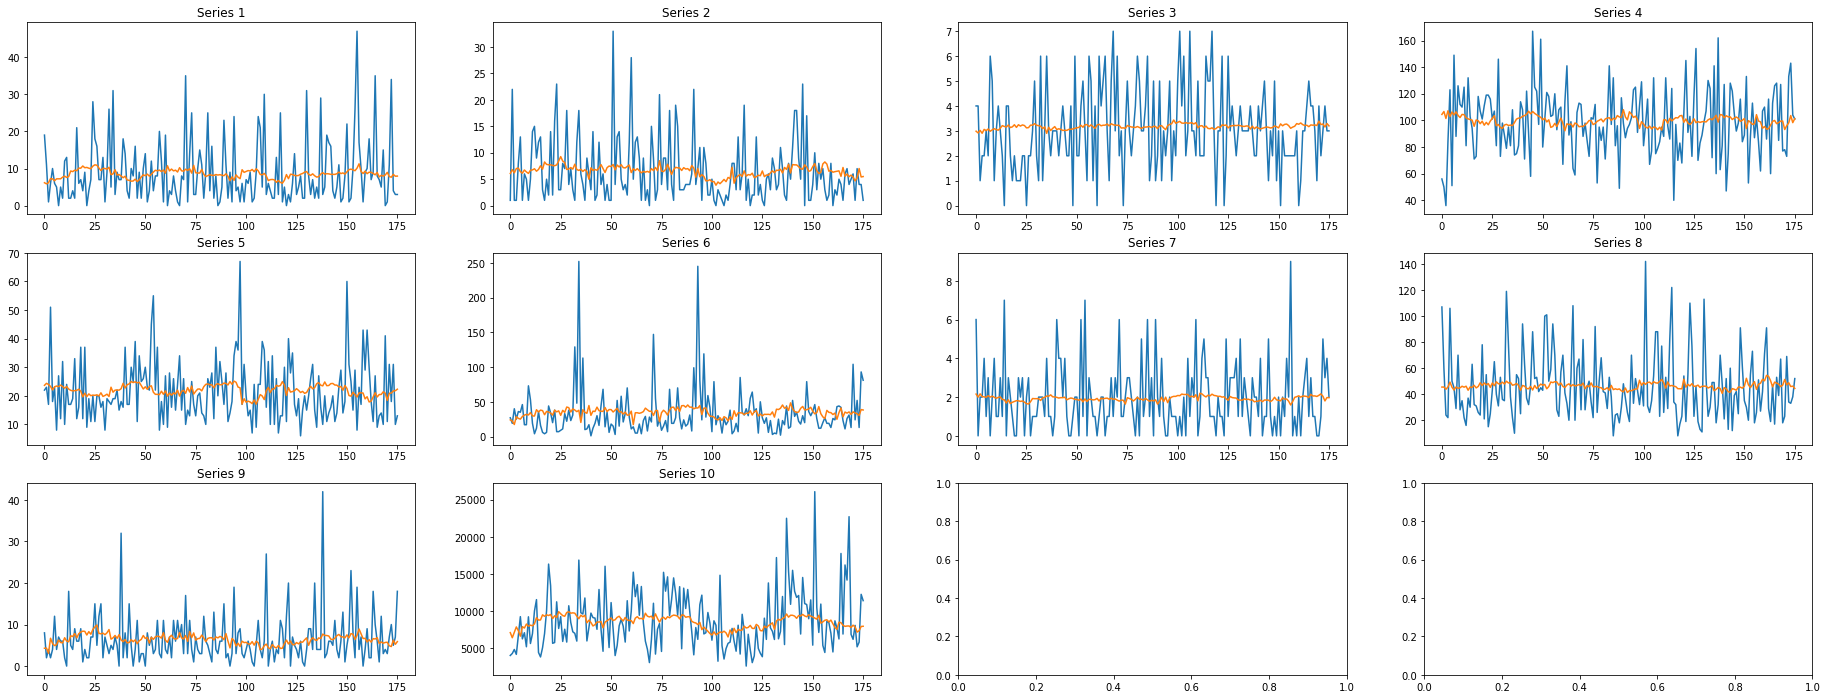

In [21]:
plot_fit(train_data[12:], orig_scale[:-1])

In [22]:
transformer_model.summary()

Model: "transformer_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_99 (Encoder)        multiple                  5972      
                                                                 
 decoder_99 (Decoder)        multiple                  11192     
                                                                 
 dense_899 (Dense)           multiple                  110       
                                                                 
Total params: 17,274
Trainable params: 17,274
Non-trainable params: 0
_________________________________________________________________


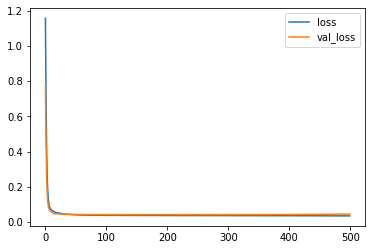

In [23]:
df = pd.DataFrame(transformer_hypertune.history.history)
df.plot(y=['loss', 'val_loss'])
plt.show()

In [25]:
transformer_model.save("transformer.tf")

INFO:tensorflow:Assets written to: transformer.tf\assets


INFO:tensorflow:Assets written to: transformer.tf\assets


In [26]:
transformer_model.save_weights('transformer_weights/transformer')

In [27]:
with open("transformer_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)